# Import libraries

In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import utils
import config
import re
import os

In [2]:
# set figure details
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
rc("svg", fonttype="none") 

# Metadata

In [3]:
metadata = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.tsv"), sep="\t", index_col=0)
metadata["date_time"] = pd.to_datetime(metadata['Date_Collected'])
metadata["Sample_ID"] = metadata.index
metadata = metadata.set_index("Patient_No", drop=False)
metadata

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,calc_age_mo,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID
Patient_No,,,,,,,,,,,,,,,,,,,,,
101,101,no,12/10/16,1430,0,regular,NaN,NaN,NaN,NaN,...,0.07,1.0,0.0,magic.0001,Knights_Project_046,magic.0001.S22.001.fa,MagAttract,1544781,2016-12-10,magic.0001
101,101,no,12/15/16,NaN,1,regular,NaN,NaN,NaN,NaN,...,0.23,1.0,0.0,magic.0004,Knights_Project_046,magic.0004.S34.001.fa,MagAttract,1167038,2016-12-15,magic.0004
104,104,yes,12/15/16,2335,0,regular,NaN,NaN,NaN,NaN,...,0.03,1.0,1.0,magic.0006,Knights_Project_076_Pool3,magic.0006.S145.001.fa,PowerSoil,1720636,2016-12-15,magic.0006
105,105,yes,12/15/16,2115,0,regular,NaN,NaN,NaN,NaN,...,0.03,1.0,1.0,magic.0007,Knights_Project_076_Pool3,magic.0007.S155.001.fa,PowerSoil,6825017,2016-12-15,magic.0007
105,105,yes,12/15/16,1525,0,regular,NaN,NaN,NaN,NaN,...,0.03,1.0,1.0,magic.0008,Knights_Project_055,X8.S125.001.fa,PowerSoil,2928044,2016-12-15,magic.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,588,NaN,8/22/21,1702,96,regular,NaN,NaN,NaN,NaN,...,24.11,NaN,NaN,magic.6595,Knights_Project_077_Pool3,magic.6595.S253.001.fa,PowerSoilPro,1562968,2021-08-22,magic.6595
595,595,NaN,9/6/21,NaN,96,regular,NaN,NaN,NaN,formed,...,24.11,NaN,NaN,magic.6597,Knights_Project_077_Pool3,magic.6597.S265.001.fa,PowerSoilPro,2113880,2021-09-06,magic.6597
585,585,NaN,8/23/21,725,96,regular,NaN,NaN,NaN,formed,...,24.34,NaN,NaN,magic.6598,Knights_Project_077_Pool3,magic.6598.S277.001.fa,PowerSoilPro,1650388,2021-08-23,magic.6598


In [4]:
abx = pd.read_csv(os.path.join(config.RAW_DIR, "MAGIC_outpatientCHOP_antimicrob_041223.xlsx - anti-infOPT_deid.tsv"), sep="\t", index_col=1)
abx = abx.drop(["SIG", "MED_NAME"], axis=1)
abx["START_DATE"] = pd.to_datetime(abx["START_DATE"])
abx

,REDCAP_PARTICIPANT_ID,SIMPLE_GENERIC_NAME,ORDERING_DATE_FMT,START_DATE,END_DATE,DURATION_DAYS,REFILLS,ORDER_CLASS,ORDERING_MODE,THERA_CLASS,PHARM_SUBCLASS,PHARM_CLASS,ROUTE,DOSE,days_sig
PARTICIPANT_STUDY_ID,,,,,,,,,,,,,,,
101,1,Amoxicillin-Pot Clavulanate,2/9/2018,2018-02-09,2/19/2018,10.0,0,Print,Outpatient,Anti-Infective Agents,Penicillin Combinations,Penicillins,Oral,90 mg AMOX/kg/24 hrs 2 TIMES DAILY,10 days.
102,13,Oseltamivir Phosphate,2/22/2017,2017-02-22,2/28/2017,6.0,0,Print,Outpatient,Anti-Infective Agents,Influenza Agents,Antiviral,Oral,3 mg/kg/DOSE 2 TIMES DAILY,5 days.
102,13,Amoxicillin,1/18/2018,2018-01-18,1/28/2018,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Aminopenicillins,Penicillins,Oral,40 mg/kg/24 hrs 2 TIMES DAILY,10 days.
108,49,Cephalexin,5/8/2018,2018-05-08,5/18/2018,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Cephalosporins - 1st Generation,Cephalosporins,Oral,7 mL 3 TIMES DAILY,10 days.
108,49,Amoxicillin,8/24/2018,2018-08-24,9/3/2018,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Aminopenicillins,Penicillins,Oral,6 mL 2 TIMES DAILY,10 days.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1054,Cefdinir,11/6/2020,2020-11-06,11/16/2020,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Cephalosporins - 3rd Generation,Cephalosporins,Oral,14 mg/kg/24 hrs DAILY,10 days.
594,1054,Cefdinir,4/19/2021,2021-04-19,4/29/2021,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Cephalosporins - 3rd Generation,Cephalosporins,Oral,14 mg/kg/24 hrs DAILY,10 days.
594,1054,Cefdinir,6/3/2021,2021-06-03,6/13/2021,10.0,0,E-Prescribe,Outpatient,Anti-Infective Agents,Cephalosporins - 3rd Generation,Cephalosporins,Oral,14 mg/kg/24 hrs DAILY,10 days.


In [5]:
participants = set(abx.index)
participants

{101,
 102,
 108,
 109,
 110,
 111,
 113,
 120,
 123,
 132,
 133,
 138,
 143,
 144,
 147,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 161,
 167,
 171,
 177,
 181,
 190,
 194,
 196,
 200,
 201,
 202,
 204,
 206,
 207,
 210,
 212,
 214,
 216,
 220,
 221,
 224,
 225,
 231,
 237,
 239,
 240,
 241,
 249,
 250,
 252,
 256,
 261,
 263,
 264,
 265,
 272,
 273,
 275,
 277,
 278,
 279,
 280,
 281,
 284,
 286,
 290,
 292,
 294,
 295,
 297,
 298,
 306,
 307,
 310,
 312,
 313,
 330,
 331,
 334,
 335,
 336,
 339,
 340,
 341,
 343,
 344,
 346,
 349,
 353,
 356,
 357,
 359,
 360,
 362,
 364,
 365,
 373,
 375,
 376,
 380,
 386,
 388,
 389,
 390,
 392,
 396,
 397,
 398,
 401,
 403,
 406,
 407,
 415,
 417,
 418,
 428,
 429,
 431,
 433,
 434,
 444,
 445,
 449,
 451,
 453,
 455,
 460,
 461,
 464,
 467,
 470,
 471,
 473,
 476,
 479,
 480,
 482,
 488,
 491,
 493,
 494,
 497,
 502,
 504,
 505,
 509,
 514,
 519,
 522,
 524,
 528,
 529,
 532,
 537,
 538,
 546,
 547,
 554,
 559,
 560,
 565,
 572,
 575,
 577,
 585

In [6]:
reduced_metadata = metadata[metadata["Patient_No"].apply(lambda x : x in participants)]

In [7]:
reduced_metadata

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,calc_age_mo,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID
Patient_No,,,,,,,,,,,,,,,,,,,,,
101,101,no,12/10/16,1430,0,regular,NaN,NaN,NaN,NaN,...,0.07,1.0,0.0,magic.0001,Knights_Project_046,magic.0001.S22.001.fa,MagAttract,1544781,2016-12-10,magic.0001
101,101,no,12/15/16,NaN,1,regular,NaN,NaN,NaN,NaN,...,0.23,1.0,0.0,magic.0004,Knights_Project_046,magic.0004.S34.001.fa,MagAttract,1167038,2016-12-15,magic.0004
101,101,no,12/10/16,2230,0,regular,NaN,NaN,NaN,NaN,...,0.07,1.0,0.0,magic.0010,Knights_Project_076_Pool3,magic.0010.S167.001.fa,PowerSoil,7251673,2016-12-10,magic.0010
102,102,no,12/19/16,2142,1,regular,NaN,NaN,NaN,watery,...,0.23,1.0,0.0,magic.0013,Knights_Project_046,magic.0013.S58.001.fa,MagAttract,1263330,2016-12-19,magic.0013
101,101,no,NaN,NaN,2,regular,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,magic.0016,Knights_Project_046,magic.0016.S82.001.fa,MagAttract,979090,NaT,magic.0016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,5/1/21,749,84,regular,NaN,NaN,NaN,soft,...,21.09,NaN,NaN,magic.6559,Knights_Project_077_Pool1,magic.6559.S282.001.fa,PowerSoilPro,6466793,2021-05-01,magic.6559
577,577,NaN,8/4/21,1945,96,regular,NaN,NaN,NaN,formed,...,24.21,NaN,NaN,magic.6585,Knights_Project_077_Pool3,magic.6585.S240.001.fa,PowerSoilPro,1885529,2021-08-04,magic.6585
572,572,NaN,7/28/21,815,96,regular,NaN,NaN,NaN,formed,...,24.47,NaN,NaN,magic.6593,Knights_Project_077_Pool3,magic.6593.S229.001.fa,PowerSoilPro,1329640,2021-07-28,magic.6593


In [8]:
reduced_metadata["days_since_last_start_abx"] = -420
reduced_metadata

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_86078/3222683304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_metadata["days_since_last_start_abx"] = -420


,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx
Patient_No,,,,,,,,,,,,,,,,,,,,,
101,101,no,12/10/16,1430,0,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0001,Knights_Project_046,magic.0001.S22.001.fa,MagAttract,1544781,2016-12-10,magic.0001,-420
101,101,no,12/15/16,NaN,1,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0004,Knights_Project_046,magic.0004.S34.001.fa,MagAttract,1167038,2016-12-15,magic.0004,-420
101,101,no,12/10/16,2230,0,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0010,Knights_Project_076_Pool3,magic.0010.S167.001.fa,PowerSoil,7251673,2016-12-10,magic.0010,-420
102,102,no,12/19/16,2142,1,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0013,Knights_Project_046,magic.0013.S58.001.fa,MagAttract,1263330,2016-12-19,magic.0013,-420
101,101,no,NaN,NaN,2,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0016,Knights_Project_046,magic.0016.S82.001.fa,MagAttract,979090,NaT,magic.0016,-420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,5/1/21,749,84,regular,NaN,NaN,NaN,soft,...,NaN,NaN,magic.6559,Knights_Project_077_Pool1,magic.6559.S282.001.fa,PowerSoilPro,6466793,2021-05-01,magic.6559,-420
577,577,NaN,8/4/21,1945,96,regular,NaN,NaN,NaN,formed,...,NaN,NaN,magic.6585,Knights_Project_077_Pool3,magic.6585.S240.001.fa,PowerSoilPro,1885529,2021-08-04,magic.6585,-420
572,572,NaN,7/28/21,815,96,regular,NaN,NaN,NaN,formed,...,NaN,NaN,magic.6593,Knights_Project_077_Pool3,magic.6593.S229.001.fa,PowerSoilPro,1329640,2021-07-28,magic.6593,-420


In [9]:
for part in participants:
    part_abx = abx.loc[[part]]
    part_samples = reduced_metadata[reduced_metadata["Patient_No"] == part]
    part_samples_dates = part_samples["date_time"]
    if part_samples_dates.shape[0] == 0: continue
    start_dates = part_abx["START_DATE"]
#     display("start:", start_dates)
#     display("sample dates:", part_samples_dates)
    
    times = np.zeros((start_dates.shape[0], part_samples_dates.shape[0]))
    
    for i in range(start_dates.shape[0]):
        for j in range(part_samples_dates.shape[0]):
            dif = (part_samples_dates.iloc[j] - start_dates.iloc[i]).days
            times[i, j] = dif
            
    idx = np.argmin(np.abs(times), axis=0)
    day_info = times[idx, np.arange(idx.shape[0])]
    reduced_metadata.loc[[part], "days_since_last_start_abx"] = day_info
#     display(reduced_metadata.loc[part])
#     input()

In [13]:
for part in participants:
    display(abx.loc[part]["START_DATE"])
    display(reduced_metadata[reduced_metadata["Patient_No"] == part][["date_time", "days_since_last_start_abx"]].sort_values("date_time"))
    input()

PARTICIPANT_STUDY_ID
514   2020-02-04
514   2020-03-03
Name: START_DATE, dtype: datetime64[ns]

,date_time,days_since_last_start_abx
Patient_No,,
514,2019-01-21,-379.0
514,2019-02-13,-356.0
514,2019-04-17,-293.0
514,2019-07-16,-203.0
514,2020-01-25,-10.0
514,2021-01-20,323.0


KeyboardInterrupt: Interrupted by user

In [19]:
plot_range = reduced_metadata[(reduced_metadata["days_since_last_start_abx"] >= -30) & (reduced_metadata["days_since_last_start_abx"] <= 30)]
plot_range

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx
Patient_No,,,,,,,,,,,,,,,,,,,,,
120,120,yes,1/12/17,1250,0,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0039,Knights_Project_055,X39.S150.001.fa,PowerSoil,2263145,2017-01-12,magic.0039,-26.0
120,120,no,1/17/17,2015,1,regular,NaN,NaN,NaN,soft,...,1.0,0.0,magic.0079,Knights_Project_046,magic.0079.S84.001.fa,MagAttract,1175404,2017-01-17,magic.0079,-21.0
120,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0107,Knights_Project_068_Pool1,magic.0107.S84.001.fa,PowerSoil,8140140,2017-01-31,magic.0107,-7.0
120,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,1.0,0.0,magic.0115,Knights_Project_068_Pool1,magic.0115.S38.001.fa,PowerSoil,27695932,2017-02-08,magic.0115,1.0
120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0120,Knights_Project_076_Pool3,magic.0120.S149.001.fa,PowerSoil,6189372,2017-01-24,magic.0120,-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,2/24/20,1800,NaN,abx,NaN,after,10,soft,...,NaN,NaN,magic.6471,Knights_Project_077_Pool3,magic.6471.S211.001.fa,PowerSoilPro,1328446,2020-02-24,magic.6471,5.0
577,577,NaN,1/30/21,1740,72,regular,NaN,NaN,NaN,formed,...,NaN,NaN,magic.6501,Knights_Project_077_Pool3,magic.6501.S224.001.fa,PowerSoilPro,1546830,2021-01-30,magic.6501,-4.0
594,594,NaN,4/23/21,1853,NaN,abx,NaN,during,5,formed,...,NaN,NaN,magic.6535,Knights_Project_077_Pool3,magic.6535.S273.001.fa,PowerSoilPro,1957686,2021-04-23,magic.6535,4.0


In [25]:
for part in plot_range.index.unique():
    display(plot_range.loc[[part]].sort_values("date_time"))
    input()

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx
Patient_No,,,,,,,,,,,,,,,,,,,,,
120,120,yes,1/12/17,1250,0,regular,NaN,NaN,NaN,NaN,...,1.0,0.0,magic.0039,Knights_Project_055,X39.S150.001.fa,PowerSoil,2263145,2017-01-12,magic.0039,-26.0
120,120,no,1/17/17,2015,1,regular,NaN,NaN,NaN,soft,...,1.0,0.0,magic.0079,Knights_Project_046,magic.0079.S84.001.fa,MagAttract,1175404,2017-01-17,magic.0079,-21.0
120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0120,Knights_Project_076_Pool3,magic.0120.S149.001.fa,PowerSoil,6189372,2017-01-24,magic.0120,-14.0
120,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0107,Knights_Project_068_Pool1,magic.0107.S84.001.fa,PowerSoil,8140140,2017-01-31,magic.0107,-7.0
120,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,1.0,0.0,magic.0115,Knights_Project_068_Pool1,magic.0115.S38.001.fa,PowerSoil,27695932,2017-02-08,magic.0115,1.0


,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx
Patient_No,,,,,,,,,,,,,,,,,,,,,
102,102,no,3/12/17,1145,12,regular,NaN,NaN,NaN,soft,...,1.0,0.0,magic.0230,Knights_Project_055,X230.S144.001.fa,PowerSoil,2405023,2017-03-12,magic.0230,18.0
102,102,no,1/23/18,805,na,Abx,NaN,during,5,formed,...,0.0,0.0,magic.1349,Knights_Project_068_Pool2,magic.1349.S443.001.fa,PowerSoil,7394378,2018-01-23,magic.1349,5.0
102,102,no,1/31/18,815,na,Abx,NaN,after,2,hard,...,0.0,0.0,magic.1320,Knights_Project_068_Pool2,magic.1320.S464.001.fa,PowerSoil,10440546,2018-01-31,magic.1320,13.0
102,102,no,2/7/18,845,na,Abx,NaN,after,10,formed,...,0.0,0.0,magic.1362,Knights_Project_068_Pool2,magic.1362.S397.001.fa,PowerSoil,8929570,2018-02-07,magic.1362,20.0


KeyboardInterrupt: Interrupted by user

In [13]:
metadata = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata.tsv"), sep="\t", index_col=0)
metadata

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,expo_cat1,expo_cat2,calc_age_mo,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth
Sample_ID,,,,,,,,,,,,,,,,,,,,,
magic.0001,101,no,12/10/16,1430,0,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,0.07,1.0,0.0,magic.0001,Knights_Project_046,magic.0001.S22.001.fa,MagAttract,1544781
magic.0004,101,no,12/15/16,NaN,1,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,0.23,1.0,0.0,magic.0004,Knights_Project_046,magic.0004.S34.001.fa,MagAttract,1167038
magic.0006,104,yes,12/15/16,2335,0,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,0.03,1.0,1.0,magic.0006,Knights_Project_076_Pool3,magic.0006.S145.001.fa,PowerSoil,1720636
magic.0007,105,yes,12/15/16,2115,0,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,0.03,1.0,1.0,magic.0007,Knights_Project_076_Pool3,magic.0007.S155.001.fa,PowerSoil,6825017
magic.0008,105,yes,12/15/16,1525,0,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,0.03,1.0,1.0,magic.0008,Knights_Project_055,X8.S125.001.fa,PowerSoil,2928044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.6595,588,NaN,8/22/21,1702,96,regular,NaN,NaN,NaN,NaN,...,No antibiotics,Vaginal,24.11,NaN,NaN,magic.6595,Knights_Project_077_Pool3,magic.6595.S253.001.fa,PowerSoilPro,1562968
magic.6597,595,NaN,9/6/21,NaN,96,regular,NaN,NaN,NaN,formed,...,No antibiotics,Vaginal,24.11,NaN,NaN,magic.6597,Knights_Project_077_Pool3,magic.6597.S265.001.fa,PowerSoilPro,2113880
magic.6598,585,NaN,8/23/21,725,96,regular,NaN,NaN,NaN,formed,...,GBS antibiotics,C-section with labor,24.34,NaN,NaN,magic.6598,Knights_Project_077_Pool3,magic.6598.S277.001.fa,PowerSoilPro,1650388


In [14]:
CAGs = pd.read_csv(os.path.join(config.CLEAN_DIR, "reduced_CAG_profiles_clean.tsv"), sep="\t", index_col=0)
CAG_richness = (CAGs > 0).sum(axis=1)
metadata["CAG Richness"] = CAG_richness

pathways = pd.read_csv(os.path.join(config.CLEAN_DIR, "humann_pathcoverage_clean.tsv"), sep="\t", index_col=0)

pathway_richness = (pathways > 0.75).sum(axis=1)
metadata["Pathway Richness"] = pathway_richness

df = pd.read_csv("../data/raw/species_rarefied.txt", sep="\t")
df = df.T
relative_abundances = df.div(df.sum(axis=1), axis=0)

species_richness = (relative_abundances > 0.00001).sum(axis=1)
shannon_diversity = -(relative_abundances * np.log(relative_abundances)).fillna(0).sum(axis=1)

metadata = metadata.loc[relative_abundances.index]

metadata["Species Richness"] = species_richness
metadata["Shannon Diversity"] = shannon_diversity

metadata

/Users/daniel/opt/anaconda3/envs/magic/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity
magic.0007,105,yes,12/15/16,2115,0,regular,NaN,NaN,NaN,NaN,...,1.0,magic.0007,Knights_Project_076_Pool3,magic.0007.S155.001.fa,PowerSoil,6825017,146,36,243,2.248965
magic.0008,105,yes,12/15/16,1525,0,regular,NaN,NaN,NaN,NaN,...,1.0,magic.0008,Knights_Project_055,X8.S125.001.fa,PowerSoil,2928044,129,39,160,1.548390
magic.0010,101,no,12/10/16,2230,0,regular,NaN,NaN,NaN,NaN,...,0.0,magic.0010,Knights_Project_076_Pool3,magic.0010.S167.001.fa,PowerSoil,7251673,126,40,150,0.932723
magic.0012,105,no,12/22/16,950,1,regular,NaN,NaN,NaN,soft,...,1.0,magic.0012,Knights_Project_076_Pool3,magic.0012.S177.001.fa,PowerSoil,8106772,152,40,304,1.928827
magic.0014,106,no,12/22/16,250,1,regular,NaN,NaN,NaN,watery,...,0.0,magic.0014,Knights_Project_068_Pool1,magic.0014.S1.001.fa,PowerSoil,15346610,150,31,209,1.177484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.6595,588,NaN,8/22/21,1702,96,regular,NaN,NaN,NaN,NaN,...,NaN,magic.6595,Knights_Project_077_Pool3,magic.6595.S253.001.fa,PowerSoilPro,1562968,119,64,873,3.794591
magic.6597,595,NaN,9/6/21,NaN,96,regular,NaN,NaN,NaN,formed,...,NaN,magic.6597,Knights_Project_077_Pool3,magic.6597.S265.001.fa,PowerSoilPro,2113880,73,52,757,4.276521
magic.6598,585,NaN,8/23/21,725,96,regular,NaN,NaN,NaN,formed,...,NaN,magic.6598,Knights_Project_077_Pool3,magic.6598.S277.001.fa,PowerSoilPro,1650388,112,67,789,3.873291
magic.6599,573,NaN,7/21/21,845,96,regular,NaN,NaN,NaN,soft,...,NaN,magic.6599,Knights_Project_077_Pool3,magic.6599.S288.001.fa,PowerSoilPro,1519641,92,52,1059,4.765721


In [15]:
gene_richness = pd.read_csv("../data/clean/rarified_gene_richness.tsv", sep="\t", index_col=0)
metadata["Gene Richness"] = gene_richness.loc[metadata.index]
metadata

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity,Gene Richness
magic.0007,105,yes,12/15/16,2115,0,regular,NaN,NaN,NaN,NaN,...,magic.0007,Knights_Project_076_Pool3,magic.0007.S155.001.fa,PowerSoil,6825017,146,36,243,2.248965,89717.0
magic.0008,105,yes,12/15/16,1525,0,regular,NaN,NaN,NaN,NaN,...,magic.0008,Knights_Project_055,X8.S125.001.fa,PowerSoil,2928044,129,39,160,1.548390,61474.0
magic.0010,101,no,12/10/16,2230,0,regular,NaN,NaN,NaN,NaN,...,magic.0010,Knights_Project_076_Pool3,magic.0010.S167.001.fa,PowerSoil,7251673,126,40,150,0.932723,62169.0
magic.0012,105,no,12/22/16,950,1,regular,NaN,NaN,NaN,soft,...,magic.0012,Knights_Project_076_Pool3,magic.0012.S177.001.fa,PowerSoil,8106772,152,40,304,1.928827,95076.0
magic.0014,106,no,12/22/16,250,1,regular,NaN,NaN,NaN,watery,...,magic.0014,Knights_Project_068_Pool1,magic.0014.S1.001.fa,PowerSoil,15346610,150,31,209,1.177484,74356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.6595,588,NaN,8/22/21,1702,96,regular,NaN,NaN,NaN,NaN,...,magic.6595,Knights_Project_077_Pool3,magic.6595.S253.001.fa,PowerSoilPro,1562968,119,64,873,3.794591,185364.0
magic.6597,595,NaN,9/6/21,NaN,96,regular,NaN,NaN,NaN,formed,...,magic.6597,Knights_Project_077_Pool3,magic.6597.S265.001.fa,PowerSoilPro,2113880,73,52,757,4.276521,176493.0
magic.6598,585,NaN,8/23/21,725,96,regular,NaN,NaN,NaN,formed,...,magic.6598,Knights_Project_077_Pool3,magic.6598.S277.001.fa,PowerSoilPro,1650388,112,67,789,3.873291,142285.0
magic.6599,573,NaN,7/21/21,845,96,regular,NaN,NaN,NaN,soft,...,magic.6599,Knights_Project_077_Pool3,magic.6599.S288.001.fa,PowerSoilPro,1519641,92,52,1059,4.765721,155385.0


In [16]:
metadata = metadata.loc[set(plot_range["Sample_ID"]) & set(metadata.index)]
metadata

/var/folders/w8/85y9rkfs49x53d7kk_ql70bc0000gn/T/ipykernel_66799/387766840.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  metadata = metadata.loc[set(plot_range["Sample_ID"]) & set(metadata.index)]


,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity,Gene Richness
magic.1288,138,no,1/20/18,945,NaN,Abx,NaN,during,5,soft,...,magic.1288,Knights_Project_068_Pool2,magic.1288.S451.001.fa,PowerSoil,10676322,174,61,717,3.137454,111933.0
magic.1598,220,no,3/12/18,1530,NaN,Abx,NaN,after,10,formed,...,magic.1598,Knights_Project_068_Pool3,magic.1598.S545.001.fa,PowerSoil,9202316,177,35,410,2.696188,93697.0
magic.5148,290,NaN,10/11/19,1700,96,regular,NaN,NaN,NaN,soft,...,magic.5148,Knights_Project_076_Pool3,magic.5148.S65.001.fa,PowerSoil,3921353,88,41,629,3.481661,64290.0
magic.1941,210,no,5/4/18,1230,NaN,Abx,NaN,during,5,soft,...,magic.1941,Knights_Project_068_Pool3,magic.1941.S628.001.fa,PowerSoil,11032655,186,58,604,3.293474,119385.0
magic.2004,151,no,5/17/18,830,NaN,Abx,NaN,during,5,soft,...,magic.2004,Knights_Project_076_Pool1,magic.2004.S249.001.fa,PowerSoil,6312993,172,61,630,3.098310,114705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.2747,111,no,10/7/18,945,NaN,abx,NaN,after,10,formed,...,magic.2747,Knights_Project_076_Pool2,magic.2747.S379.001.fa,PowerSoil,13961173,124,55,695,3.721869,160928.0
magic.3057,306,no,12/7/18,845,na,abx,NaN,prior,0,soft,...,magic.3057,Knights_Project_068_Pool4,magic.3057.S974.001.fa,PowerSoil,10920963,69,57,621,3.500180,134159.0
magic.5439,594,NaN,12/26/19,900,NaN,abx,NaN,during,5,soft,...,magic.5439,Knights_Project_077_Pool3,magic.5439.S16.001.fa,PowerSoilPro,10747617,70,24,230,1.990595,22400.0
magic.3946,360,NaN,3/25/19,NaN,NaN,abx,NaN,during,5,formed,...,magic.3946,Knights_Project_076_Pool2,magic.3946.S534.001.fa,PowerSoil,19542961,169,49,563,3.363451,123442.0


In [18]:
plot_range = plot_range[plot_range["Sample_ID"].apply(lambda x : x in set(metadata.index))]
plot_range

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_bf,currentfeed_f,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx
Patient_No,,,,,,,,,,,,,,,,,,,,,
120,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0107,Knights_Project_068_Pool1,magic.0107.S84.001.fa,PowerSoil,8140140,2017-01-31,magic.0107,-7.0
120,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,1.0,0.0,magic.0115,Knights_Project_068_Pool1,magic.0115.S38.001.fa,PowerSoil,27695932,2017-02-08,magic.0115,1.0
120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,1.0,0.0,magic.0120,Knights_Project_076_Pool3,magic.0120.S149.001.fa,PowerSoil,6189372,2017-01-24,magic.0120,-14.0
102,102,no,3/12/17,1145,12,regular,NaN,NaN,NaN,soft,...,1.0,0.0,magic.0230,Knights_Project_055,X230.S144.001.fa,PowerSoil,2405023,2017-03-12,magic.0230,18.0
109,109,no,5/29/17,840,NaN,Abx,NaN,prior,0,soft,...,0.0,1.0,magic.0423,Knights_Project_068_Pool3,magic.0423.S719.001.fa,PowerSoil,9284894,2017-05-29,magic.0423,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,2/24/20,1800,NaN,abx,NaN,after,10,soft,...,NaN,NaN,magic.6471,Knights_Project_077_Pool3,magic.6471.S211.001.fa,PowerSoilPro,1328446,2020-02-24,magic.6471,5.0
577,577,NaN,1/30/21,1740,72,regular,NaN,NaN,NaN,formed,...,NaN,NaN,magic.6501,Knights_Project_077_Pool3,magic.6501.S224.001.fa,PowerSoilPro,1546830,2021-01-30,magic.6501,-4.0
594,594,NaN,4/23/21,1853,NaN,abx,NaN,during,5,formed,...,NaN,NaN,magic.6535,Knights_Project_077_Pool3,magic.6535.S273.001.fa,PowerSoilPro,1957686,2021-04-23,magic.6535,4.0


In [29]:
metadata = metadata.loc[plot_range["Sample_ID"]]
metadata

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,currentfeed_o,Sequencing_Project,Filename,Extraction,depth,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity,Gene Richness
magic.0107,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,magic.0107,Knights_Project_068_Pool1,magic.0107.S84.001.fa,PowerSoil,8140140,178,58,459,2.496793,91622.0
magic.0115,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,magic.0115,Knights_Project_068_Pool1,magic.0115.S38.001.fa,PowerSoil,27695932,61,42,676,2.830247,24401.0
magic.0120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,magic.0120,Knights_Project_076_Pool3,magic.0120.S149.001.fa,PowerSoil,6189372,175,65,593,3.518072,106839.0
magic.0230,102,no,3/12/17,1145,12,regular,NaN,NaN,NaN,soft,...,magic.0230,Knights_Project_055,X230.S144.001.fa,PowerSoil,2405023,61,35,327,2.248185,34460.0
magic.0423,109,no,5/29/17,840,NaN,Abx,NaN,prior,0,soft,...,magic.0423,Knights_Project_068_Pool3,magic.0423.S719.001.fa,PowerSoil,9284894,114,33,342,2.539292,72427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
magic.6471,577,NaN,2/24/20,1800,NaN,abx,NaN,after,10,soft,...,magic.6471,Knights_Project_077_Pool3,magic.6471.S211.001.fa,PowerSoilPro,1328446,193,67,772,4.091632,203341.0
magic.6501,577,NaN,1/30/21,1740,72,regular,NaN,NaN,NaN,formed,...,magic.6501,Knights_Project_077_Pool3,magic.6501.S224.001.fa,PowerSoilPro,1546830,112,54,724,3.726184,122013.0
magic.6535,594,NaN,4/23/21,1853,NaN,abx,NaN,during,5,formed,...,magic.6535,Knights_Project_077_Pool3,magic.6535.S273.001.fa,PowerSoilPro,1957686,94,47,490,3.019295,94750.0
magic.6536,594,NaN,4/30/21,1900,NaN,abx,NaN,post,2,soft,...,magic.6536,Knights_Project_077_Pool3,magic.6536.S284.001.fa,PowerSoilPro,1559504,67,43,548,2.987764,99790.0


In [37]:
plot_range = plot_range.drop(["CAG Richness", "Pathway Richness", "Species Richness", "Shannon Diversity", "Gene Richness"], axis=1)

plot_range["CAG Richness"] = metadata["CAG Richness"].values
plot_range["Pathway Richness"] = metadata["Pathway Richness"].values
plot_range["Species Richness"] = metadata["Species Richness"].values
plot_range["Shannon Diversity"] = metadata["Shannon Diversity"].values
plot_range["Gene Richness"] = metadata["Gene Richness"].values

In [38]:
plot_range

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity,Gene Richness
Patient_No,,,,,,,,,,,,,,,,,,,,,
120,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,PowerSoil,8140140,2017-01-31,magic.0107,-7.0,178,58,459,2.496793,91622.0
120,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,PowerSoil,27695932,2017-02-08,magic.0115,1.0,61,42,676,2.830247,24401.0
120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,PowerSoil,6189372,2017-01-24,magic.0120,-14.0,175,65,593,3.518072,106839.0
102,102,no,3/12/17,1145,12,regular,NaN,NaN,NaN,soft,...,PowerSoil,2405023,2017-03-12,magic.0230,18.0,61,35,327,2.248185,34460.0
109,109,no,5/29/17,840,NaN,Abx,NaN,prior,0,soft,...,PowerSoil,9284894,2017-05-29,magic.0423,11.0,114,33,342,2.539292,72427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,2/24/20,1800,NaN,abx,NaN,after,10,soft,...,PowerSoilPro,1328446,2020-02-24,magic.6471,5.0,193,67,772,4.091632,203341.0
577,577,NaN,1/30/21,1740,72,regular,NaN,NaN,NaN,formed,...,PowerSoilPro,1546830,2021-01-30,magic.6501,-4.0,112,54,724,3.726184,122013.0
594,594,NaN,4/23/21,1853,NaN,abx,NaN,during,5,formed,...,PowerSoilPro,1957686,2021-04-23,magic.6535,4.0,94,47,490,3.019295,94750.0


In [46]:
plot_range.columns

Index(['Patient_No', 'Hospital', 'Date_Collected', 'Time_Collected',
       'Timeline_Weeks', 'Abx_regular', 'Abx_anomoly',
       'Abx_timeline.prior..during..after.', 'abx_day', 'Consistency', 'Color',
       'Amount', 'dob', 'babysex', 'gestational_age_wk',
       'gestational_age_days', 'weight1', 'sizeforgestationalage', 'icn',
       'icnabx', 'mat_ageatadm', 'gravidity_n', 'parity_n', 'laboronset_type',
       'rom_hr', 'deliverymethod', 'sepsisrisk', 'multip_yn',
       'weight_prepregnancy_2', 'maternalheight', 'gbs_result', 'motherrace',
       'motherethnicity', 'expo_cat1', 'expo_cat2', 'calc_age_mo',
       'currentfeed_bf', 'currentfeed_f', 'currentfeed_o',
       'Sequencing_Project', 'Filename', 'Extraction', 'depth', 'date_time',
       'Sample_ID', 'days_since_last_start_abx', 'CAG Richness',
       'Pathway Richness', 'Species Richness', 'Shannon Diversity',
       'Gene Richness'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

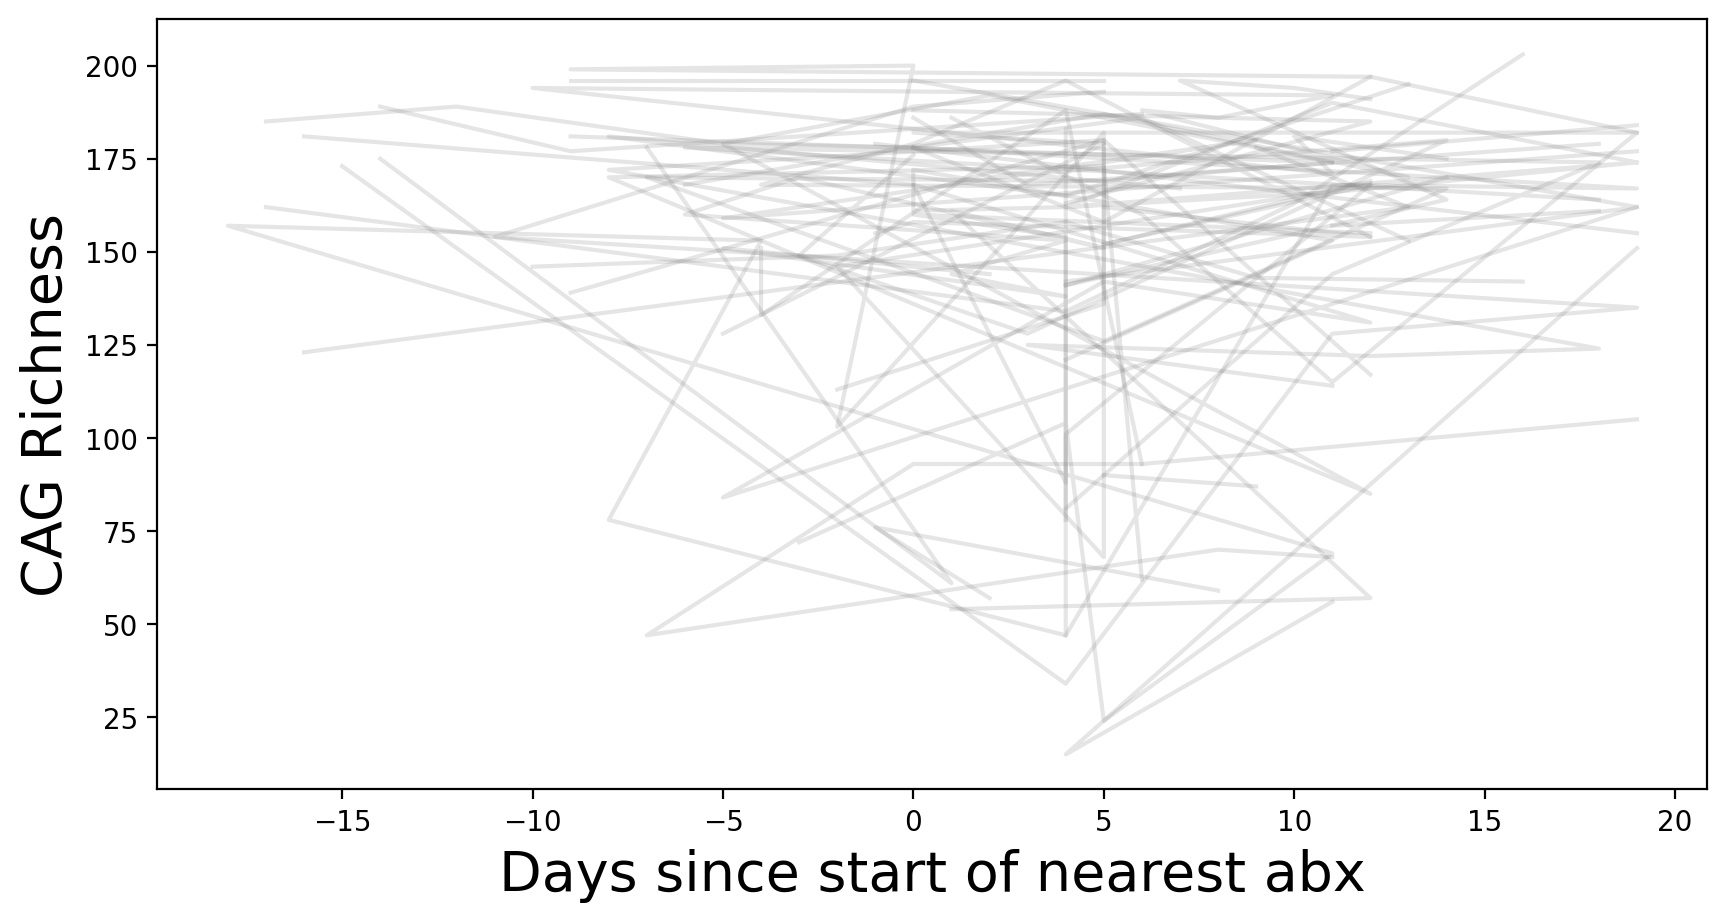

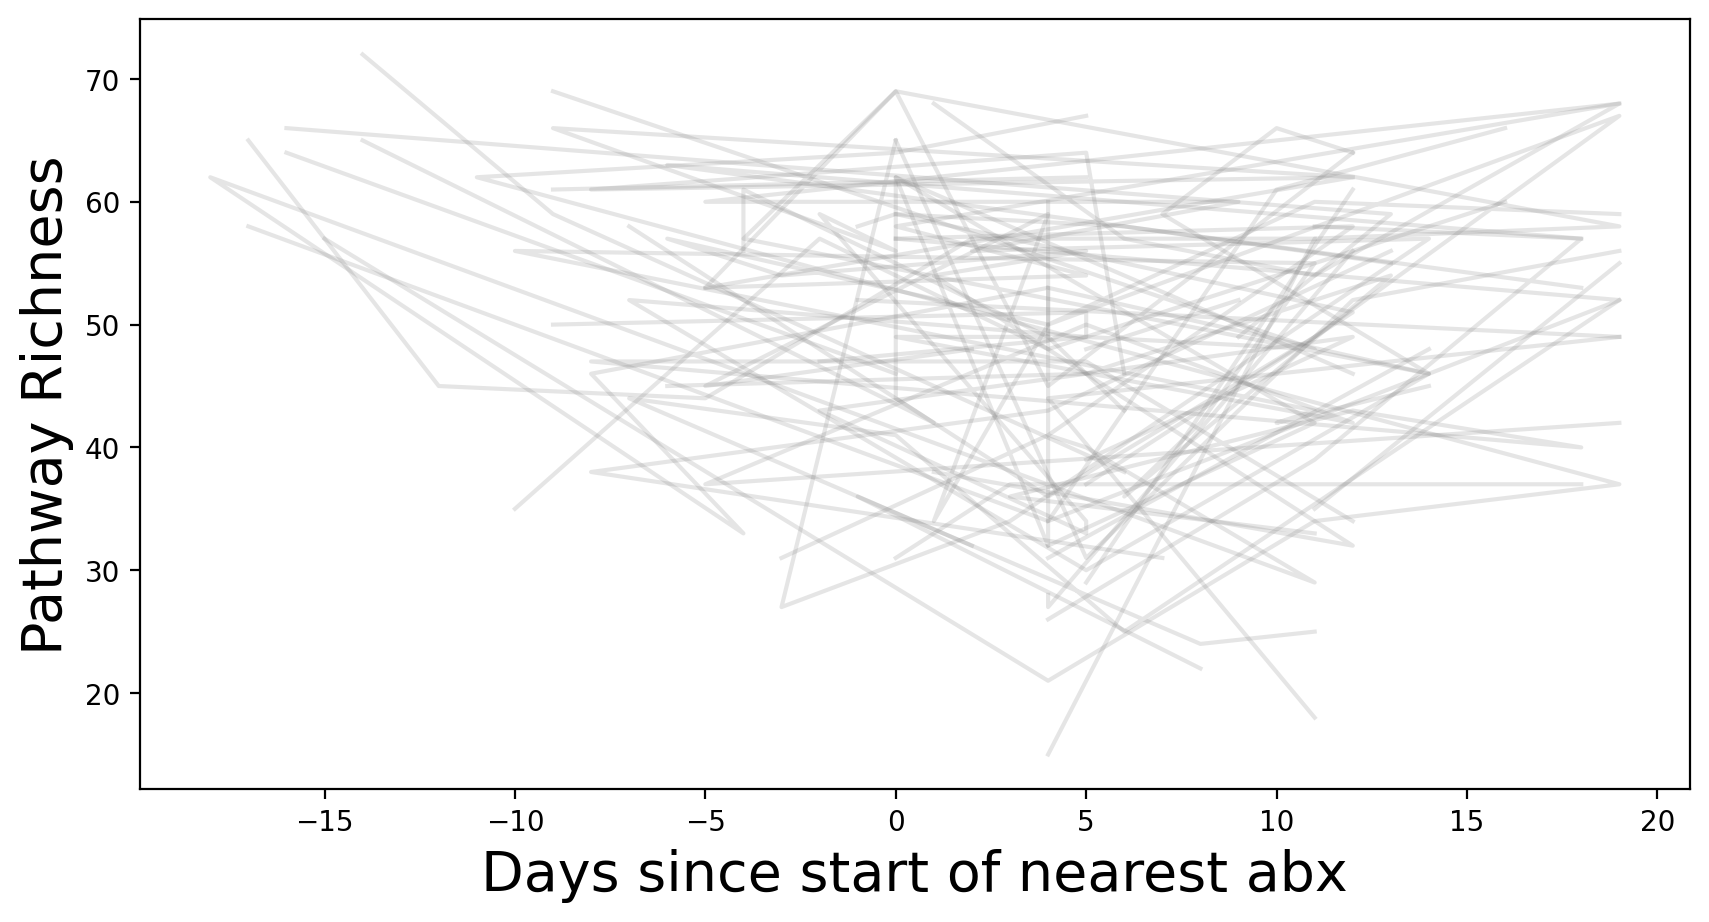

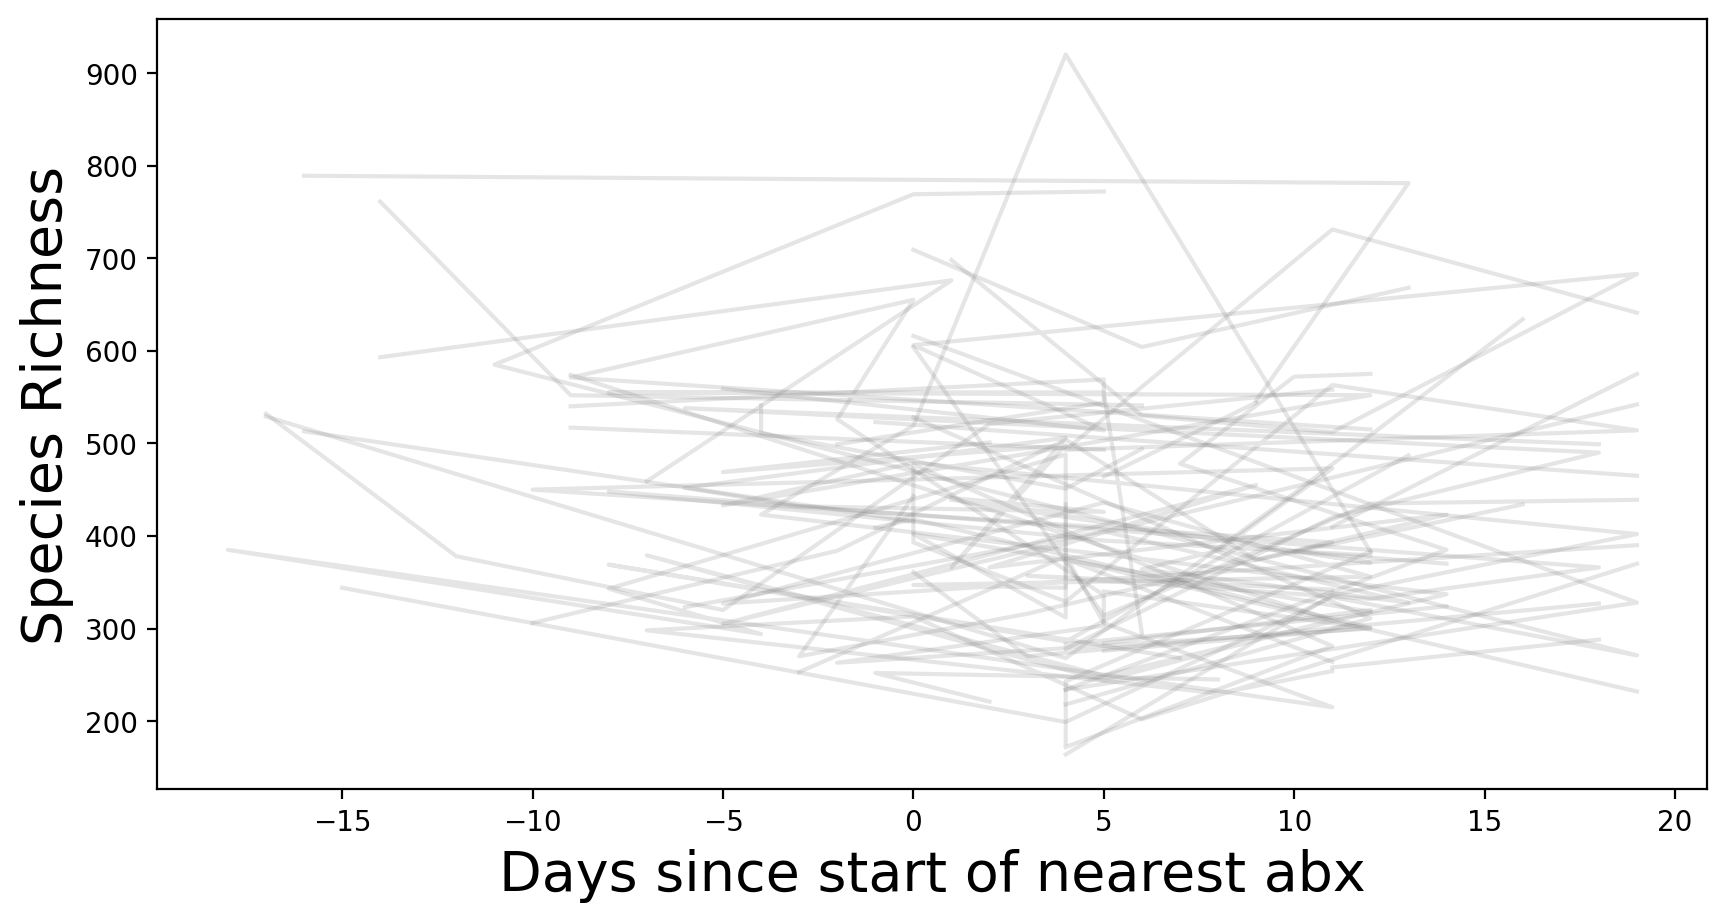

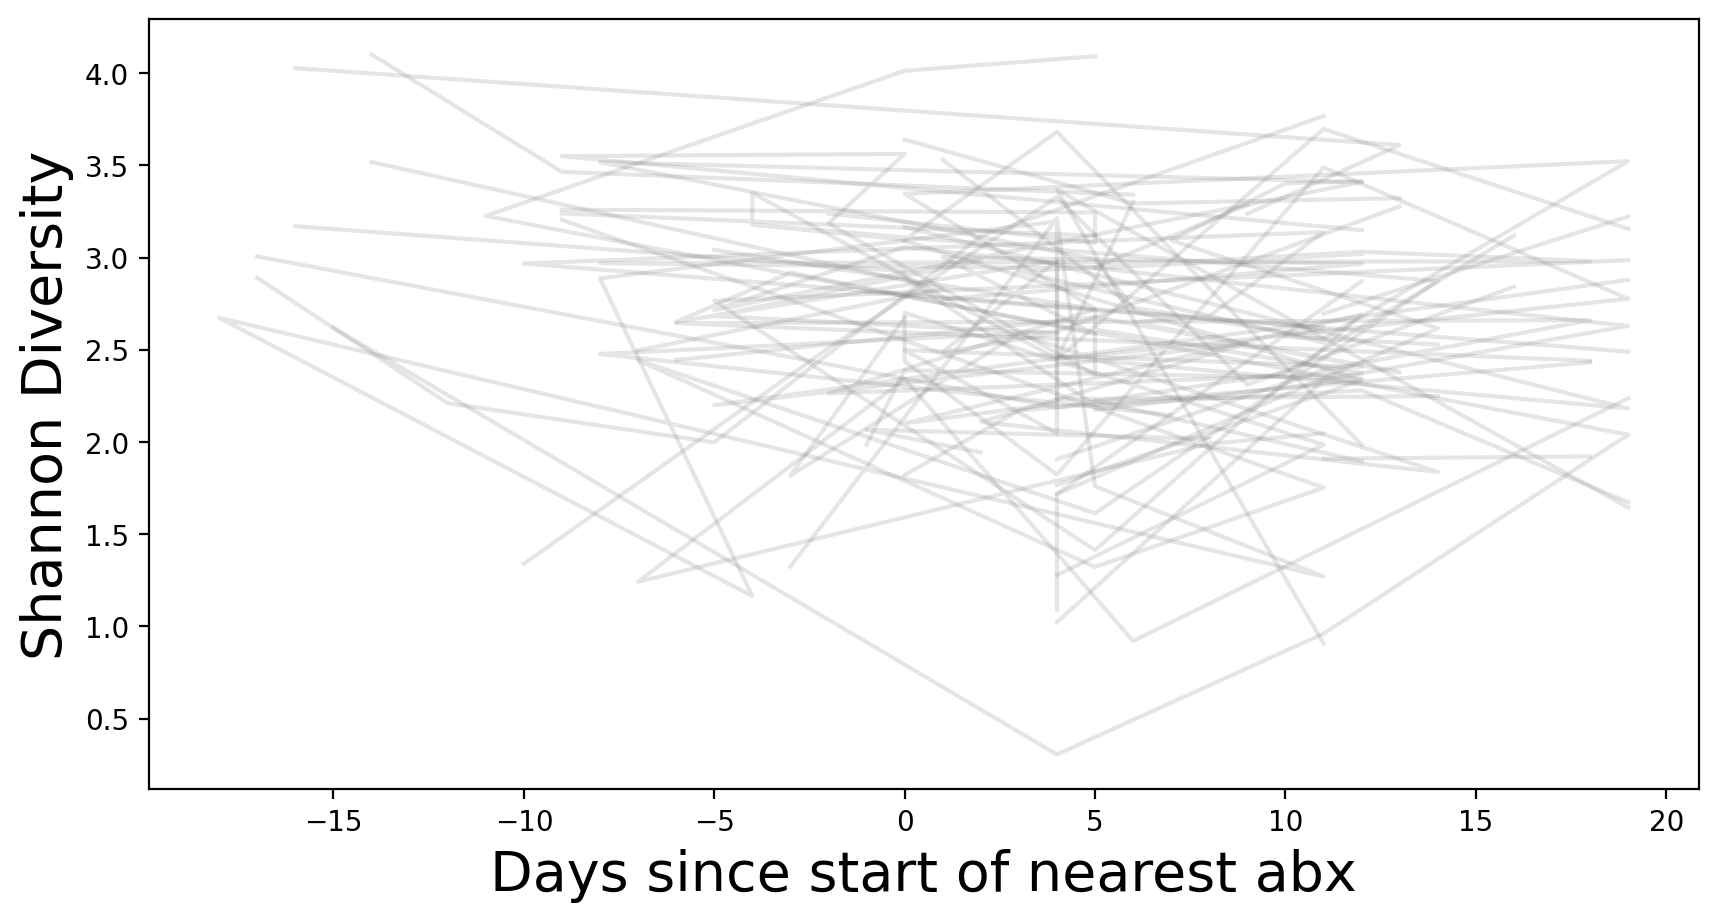

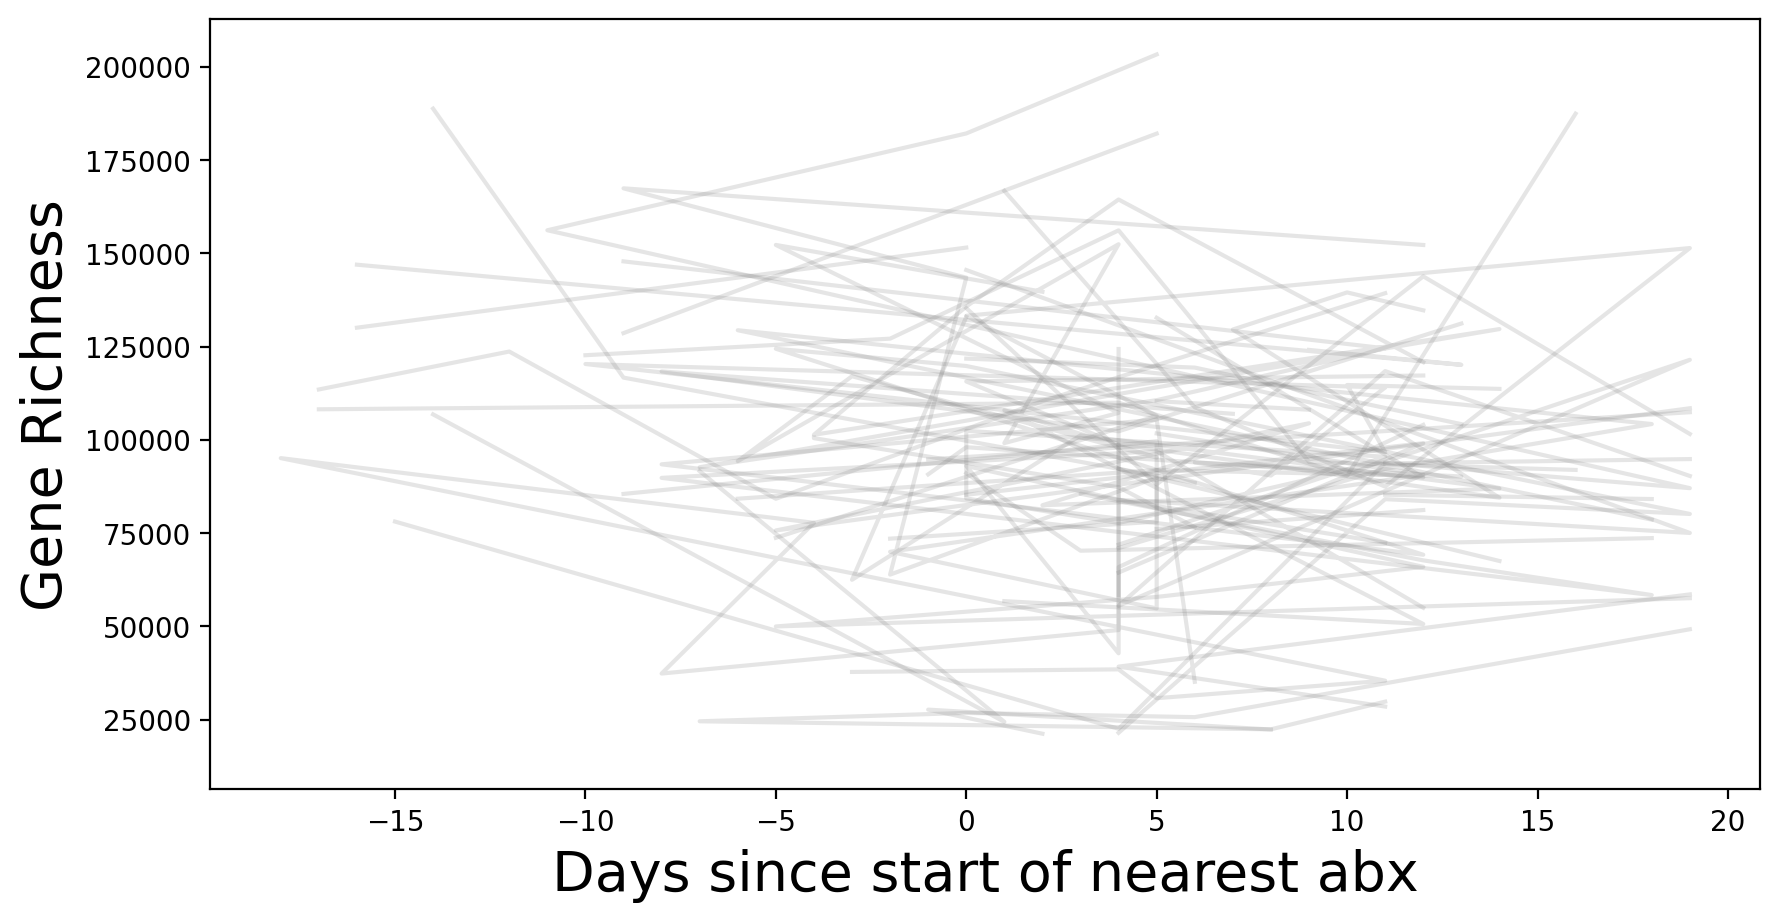

In [53]:
plt.figure(figsize=(10, 5), dpi=200)

features = ["CAG Richness", "Pathway Richness", "Species Richness", "Shannon Diversity", "Gene Richness"]

for f in features:
    plt.figure(figsize=(10, 5), dpi=200)
    cur_plot_range = plot_range[(plot_range["calc_age_mo"] > 0) & (plot_range["calc_age_mo"] < 12)]
    for p in cur_plot_range.index.unique():
        plt.plot(cur_plot_range.loc[p]["days_since_last_start_abx"], cur_plot_range.loc[p][f], c="gray", alpha=0.2)
    plt.ylabel(f, fontsize=20)
    plt.xlabel("Days since start of nearest abx", fontsize=20)
#     break

In [40]:
plot_range

,Patient_No,Hospital,Date_Collected,Time_Collected,Timeline_Weeks,Abx_regular,Abx_anomoly,Abx_timeline.prior..during..after.,abx_day,Consistency,...,Extraction,depth,date_time,Sample_ID,days_since_last_start_abx,CAG Richness,Pathway Richness,Species Richness,Shannon Diversity,Gene Richness
Patient_No,,,,,,,,,,,,,,,,,,,,,
120,120,no,1/31/17,1300,3,regular,NaN,NaN,NaN,watery,...,PowerSoil,8140140,2017-01-31,magic.0107,-7.0,178,58,459,2.496793,91622.0
120,120,no,2/8/17,1014,4,abx,yes,after,1,watery,...,PowerSoil,27695932,2017-02-08,magic.0115,1.0,61,42,676,2.830247,24401.0
120,120,no,1/24/17,1615,2,regular,NaN,NaN,NaN,watery,...,PowerSoil,6189372,2017-01-24,magic.0120,-14.0,175,65,593,3.518072,106839.0
102,102,no,3/12/17,1145,12,regular,NaN,NaN,NaN,soft,...,PowerSoil,2405023,2017-03-12,magic.0230,18.0,61,35,327,2.248185,34460.0
109,109,no,5/29/17,840,NaN,Abx,NaN,prior,0,soft,...,PowerSoil,9284894,2017-05-29,magic.0423,11.0,114,33,342,2.539292,72427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,577,NaN,2/24/20,1800,NaN,abx,NaN,after,10,soft,...,PowerSoilPro,1328446,2020-02-24,magic.6471,5.0,193,67,772,4.091632,203341.0
577,577,NaN,1/30/21,1740,72,regular,NaN,NaN,NaN,formed,...,PowerSoilPro,1546830,2021-01-30,magic.6501,-4.0,112,54,724,3.726184,122013.0
594,594,NaN,4/23/21,1853,NaN,abx,NaN,during,5,formed,...,PowerSoilPro,1957686,2021-04-23,magic.6535,4.0,94,47,490,3.019295,94750.0


In [55]:
colibactin = pd.read_csv("../data/raw/output.txt", sep="\t")
colibactin = colibactin.iloc[range(0, 5257, 2)]
colibactin

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
0,pks_cluster_NC101,1,50704,12,1179,2.32526,0.0295637,36.3,35
2,pks_cluster_NC101,1,50704,0,0,0,0,0,0
4,pks_cluster_NC101,1,50704,14,1123,2.21482,0.0347902,35.2,31.6
6,pks_cluster_NC101,1,50704,2,252,0.497002,0.00497002,28.1,25
8,pks_cluster_NC101,1,50704,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
5248,pks_cluster_NC101,1,50704,43,3831,7.55562,0.127031,35.8,36.9
5250,pks_cluster_NC101,1,50704,0,0,0,0,0,0
5252,pks_cluster_NC101,1,50704,15,1916,3.77879,0.0446316,35.4,31.1
5254,pks_cluster_NC101,1,50704,7,803,1.5837,0.0173951,30.8,42


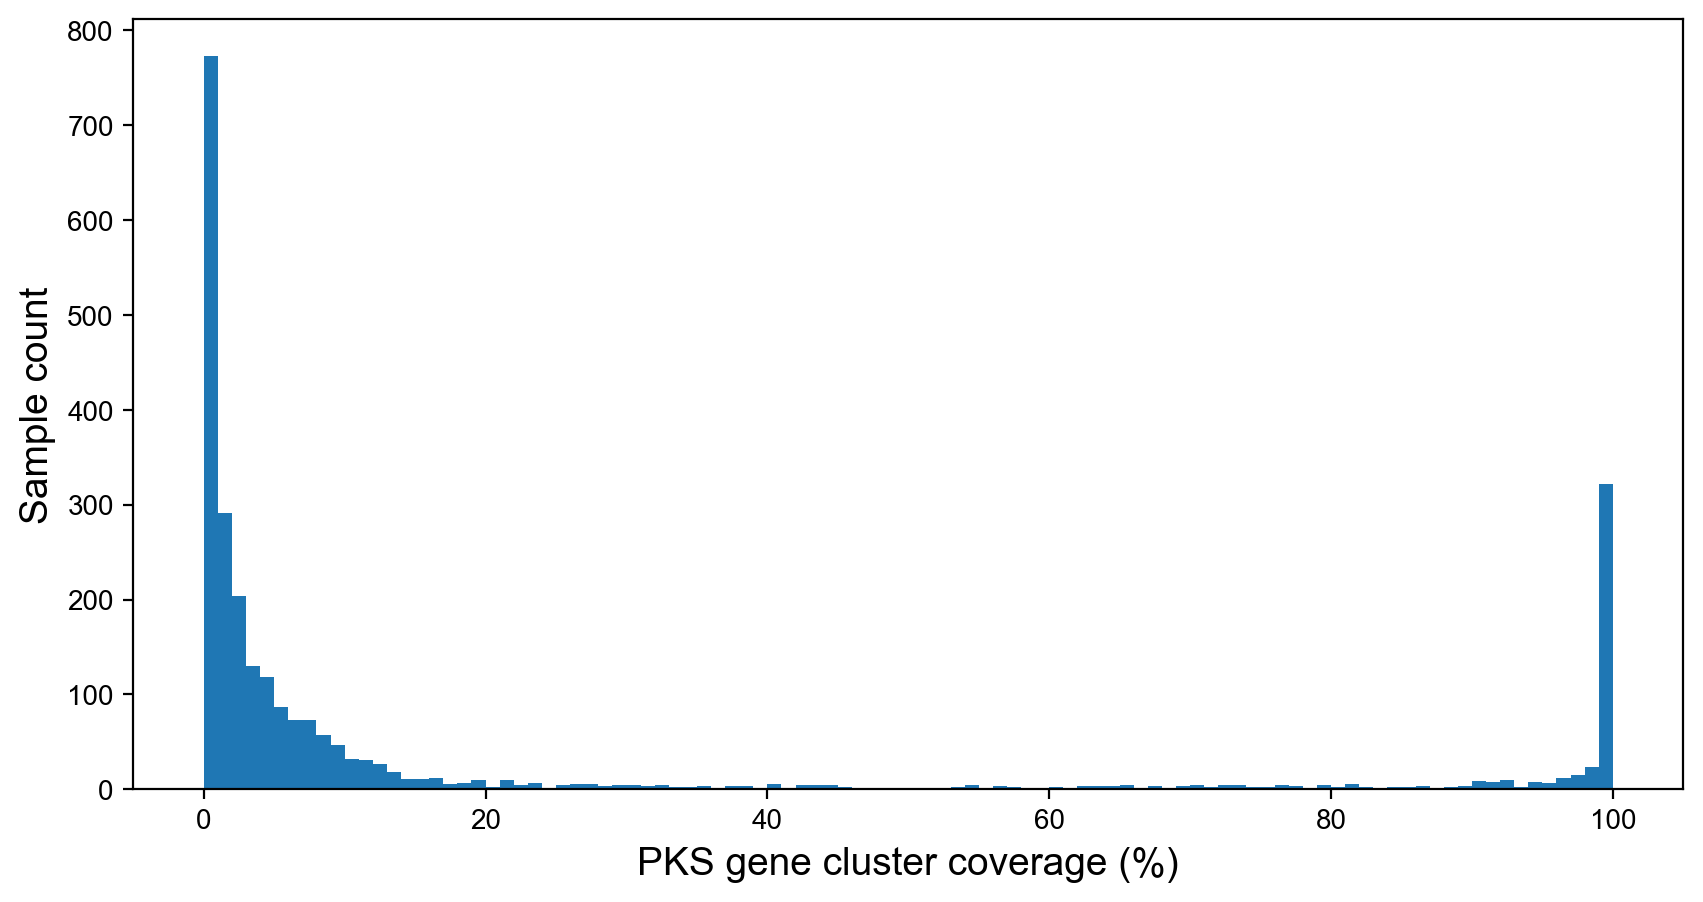

In [72]:
plt.figure(figsize=(10, 5), dpi=200)

colibactin["coverage"].astype(float).plot.hist(bins=100)

plt.ylabel("Sample count", fontname="Arial", fontsize=14)
plt.xlabel("PKS gene cluster coverage (%)", fontname="Arial", fontsize=14)
plt.xticks(fontname="Arial")
plt.yticks(fontname="Arial")

plt.savefig(os.path.join(config.FIGURE_DIR, "pks_coverage.svg"))
plt.show()

In [ ]:
# coverage vs sample depth
# coverage vs relative abundance
# send plot